In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

Ths = 3
qs = 1000
Us = 11.11
Ls = 10
Ts = 15
CNNs = 1000

q_star = 10
q_star = q_star/qs
gamma = 0.3
tau_c_ref = 0.15/1
tau_r = 0.015/1
qvs0 = 20
qvs0 = qvs0/qs


def read_tesis_data(i, **kwargs):
    mode = kwargs.get('mode', 'stocha')
    folder = 'all_data'
    u = pd.read_csv(os.path.join(folder, f'data{i}_{mode}.csv'))
    h = np.linspace(0, 15, u.shape[0])
    u.index = h
    u.columns = ['velocity', 'potential temperature', 'water vapor', 'liquid water', 'CNN']
    return u

def q_vs(z):
    a0 = 18.04 # km
    a1 = 3.27  # km
    a2 = 0.1   # km
    a4 = 1-3.48
    pz = (1- a1 * np.log(1 + a2 * z)) ** a4
    q = (qvs0 / pz)*np.exp(- a0 * ( 1 / ((1 - a1 * np.log(1 + a2*z)) * (1 + a2 * z)) - 1 ))
    # g/kg / km ** 3.48
    return q


def tau_c_inv(qn):
    return np.exp(-((qn - 0.5) / gamma) ** 2) / tau_c_ref

def cd(qv, qn, qvs):
    return np.max([qv - qvs, 0])*tau_c_inv(qn)

def ev(qv, qvs, qr):
    return np.max([qvs - qv,0]) / tau_r * qr / q_star

def cd_z(u, z):
    y = cd(u.loc[z,'water vapor'], u.loc[z,'CNN'], q_vs(z))
    return y

def ev_z(u, z):
    y = ev(u.loc[z,'water vapor'],q_vs(z), u.loc[z,'liquid water'])
    return y


## Stocha
# 10t_1 = 0.0750 min
# 10t_50 = 147 min
# 10t_101 = 300 min

## Deter (Curiosamente iban en saltos de 3 min)
# 10t_1 = 0.0750 min
# 10t_50 = 147 min
# 10t_101 = 300 min




In [2]:
def general_plot(x):
    y = x.index
    cols = x.columns
    fig = plt.figure(figsize=(6.472,4), dpi=300)
    gs = fig.add_gridspec(2,3)
    ax0 = fig.add_subplot(gs[:,0])
    ax1 = fig.add_subplot(gs[0,1])
    ax2 = fig.add_subplot(gs[1,1])
    ax3 = fig.add_subplot(gs[0,2])
    ax4 = fig.add_subplot(gs[1,2])
    ax0.plot(x[cols[0]] * Us, y, color = 'black')
    ax1.plot(x[cols[1]] * Ths, y, color = 'black')
    ax2.plot(x[cols[2]] * qs, y, color = 'black')
    ax3.plot(x[cols[3]] * qs, y, color = 'black')
    ax4.plot(x[cols[4]] * CNNs, y, color = 'black')
    ax0.set_xlabel(r'Velocidad ($ms^{-1}$)')
    ax0.set_ylabel('Altura')
    ax0.set_yticks([0,3,6,9,12,15])
    ax1.set_xlabel('Temperatura Potencial (K)')
    ax1.set_yticks([0,3,6,9,12,15])
    ax2.set_xlabel(r'Vapor de Agua ($gkg^{-1}$)')
    ax2.set_yticks([0,3,6,9,12,15])
    ax3.set_xlabel(r'Agua Líquida ($gkg^{-1}$)')
    ax3.set_yticks([0,3,6,9,12,15])
    ax4.set_xlabel(r'NCN ($pcm^{-1}$)')
    ax4.set_yticks([0,3,6,9,12,15])
    plt.tight_layout()
    return fig







In [3]:
def plot_q(d1):
    height = d1.index
    qvs = [q_vs(z / Ls) for z in height]
    fig = plt.figure(figsize=(6.472,4), dpi=300)
    plt.plot(qs * (d1['water vapor'] - qvs), height, color = 'black')
    # plt.xlabel(r'$Q_*(z) = q_{v}(t^*,z) - q_{vs}$ ($gkg^{-1}$)')
    plt.xlabel(r'$Q_*$ ($gkg^{-1}$)')
    plt.ylabel('Altura')
    plt.yticks([0,3,6,9,12,15])
    plt.plot([0,0],[0, 15], 'r--', lw = 1)
    return fig




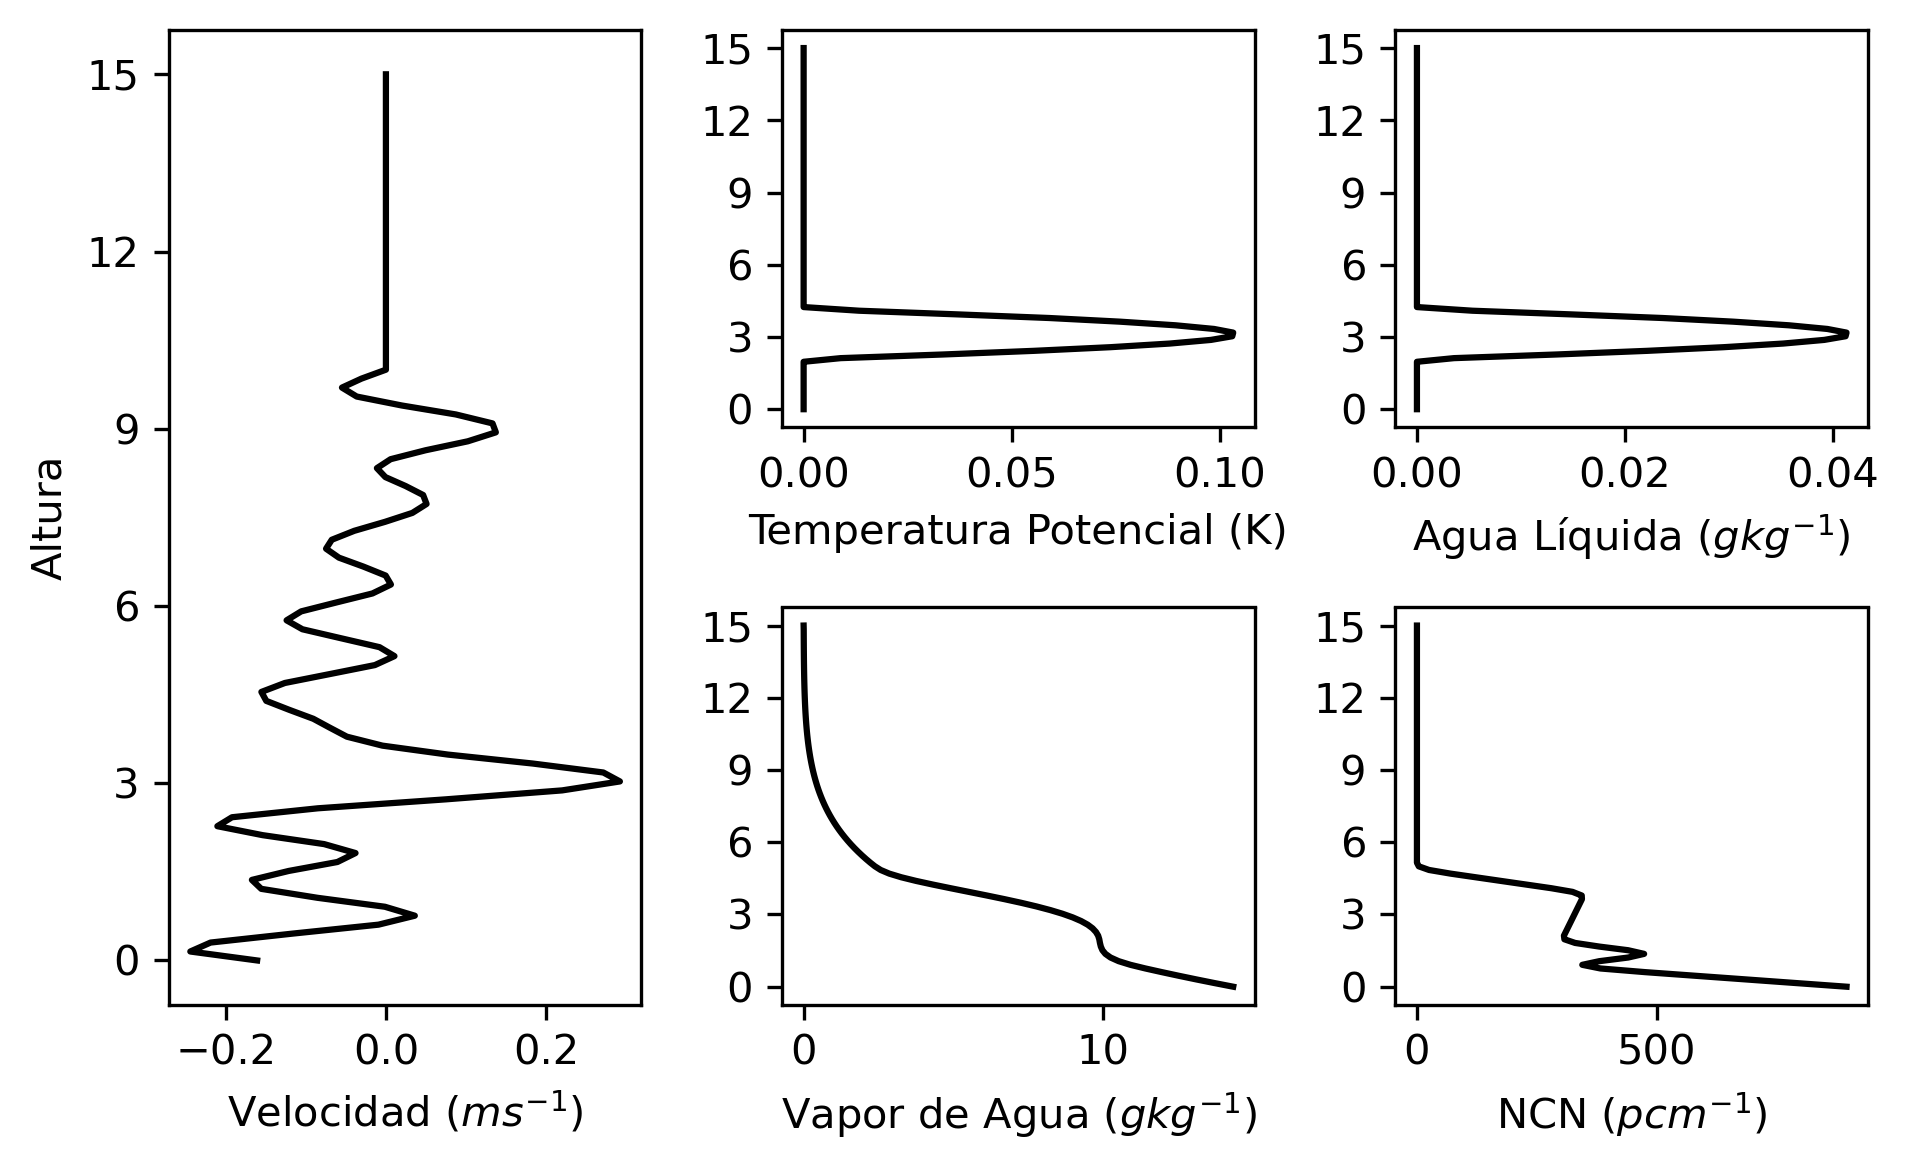

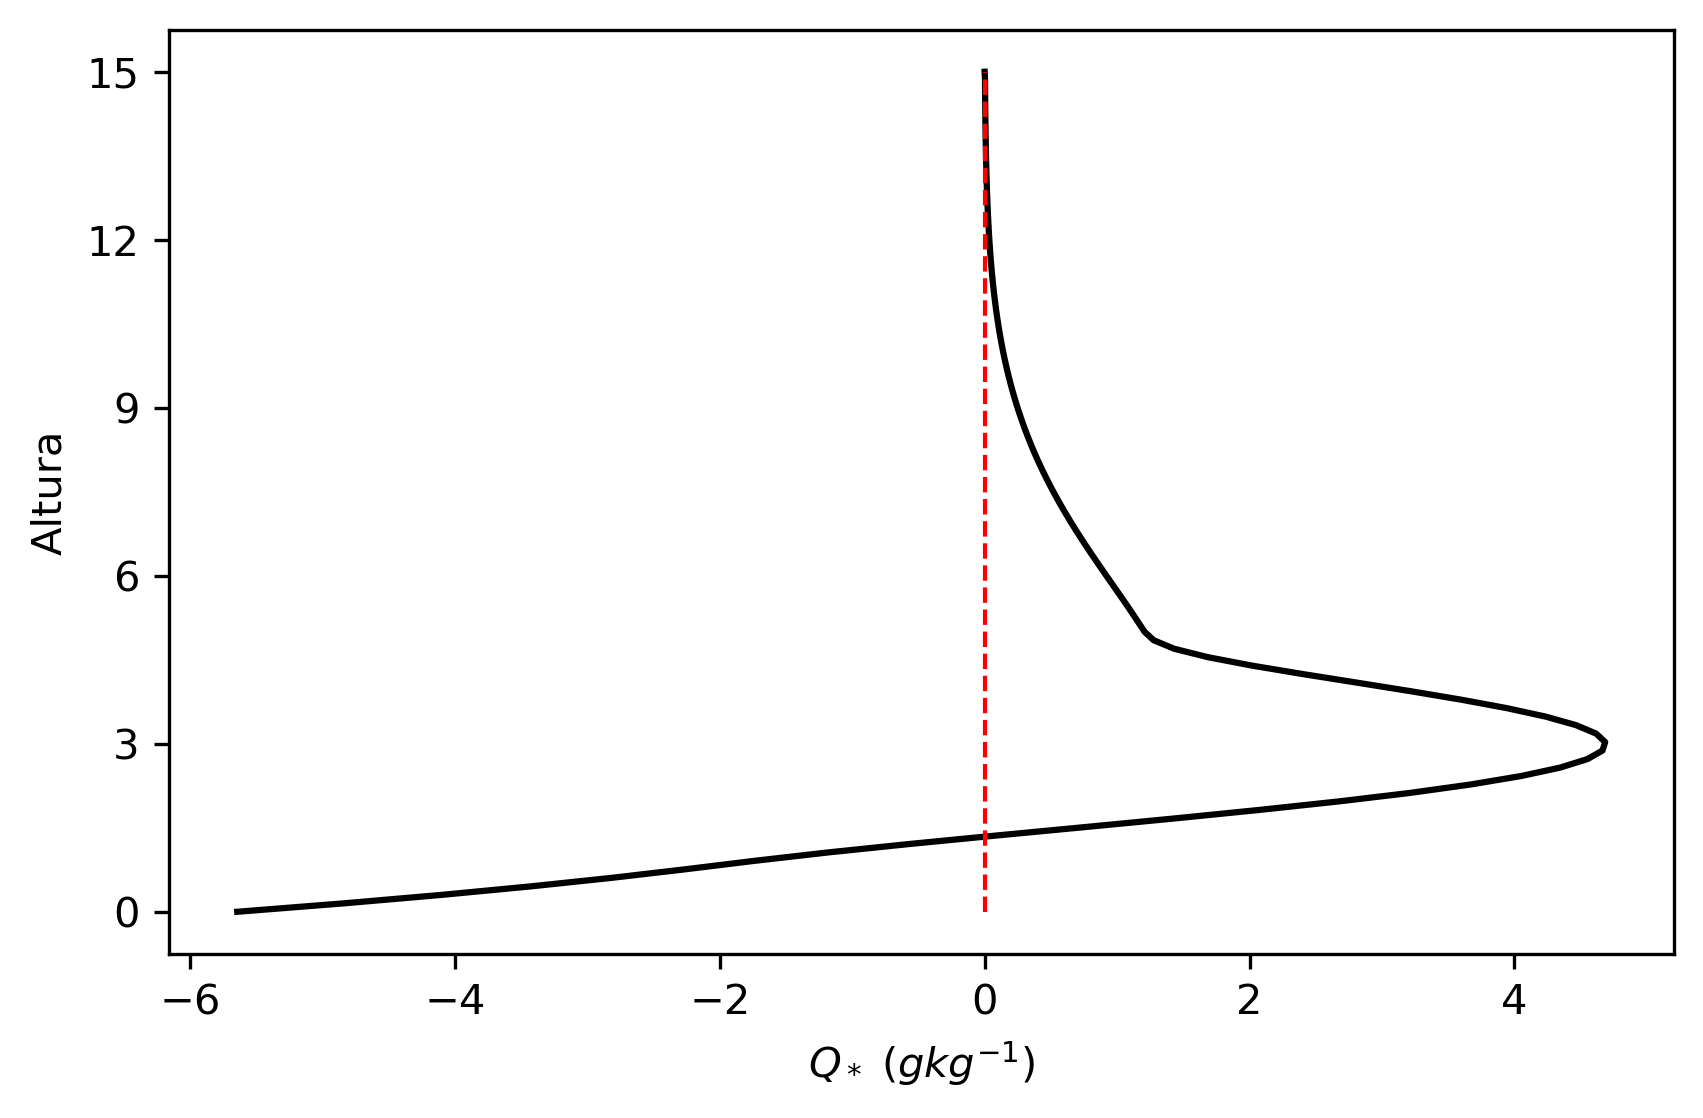

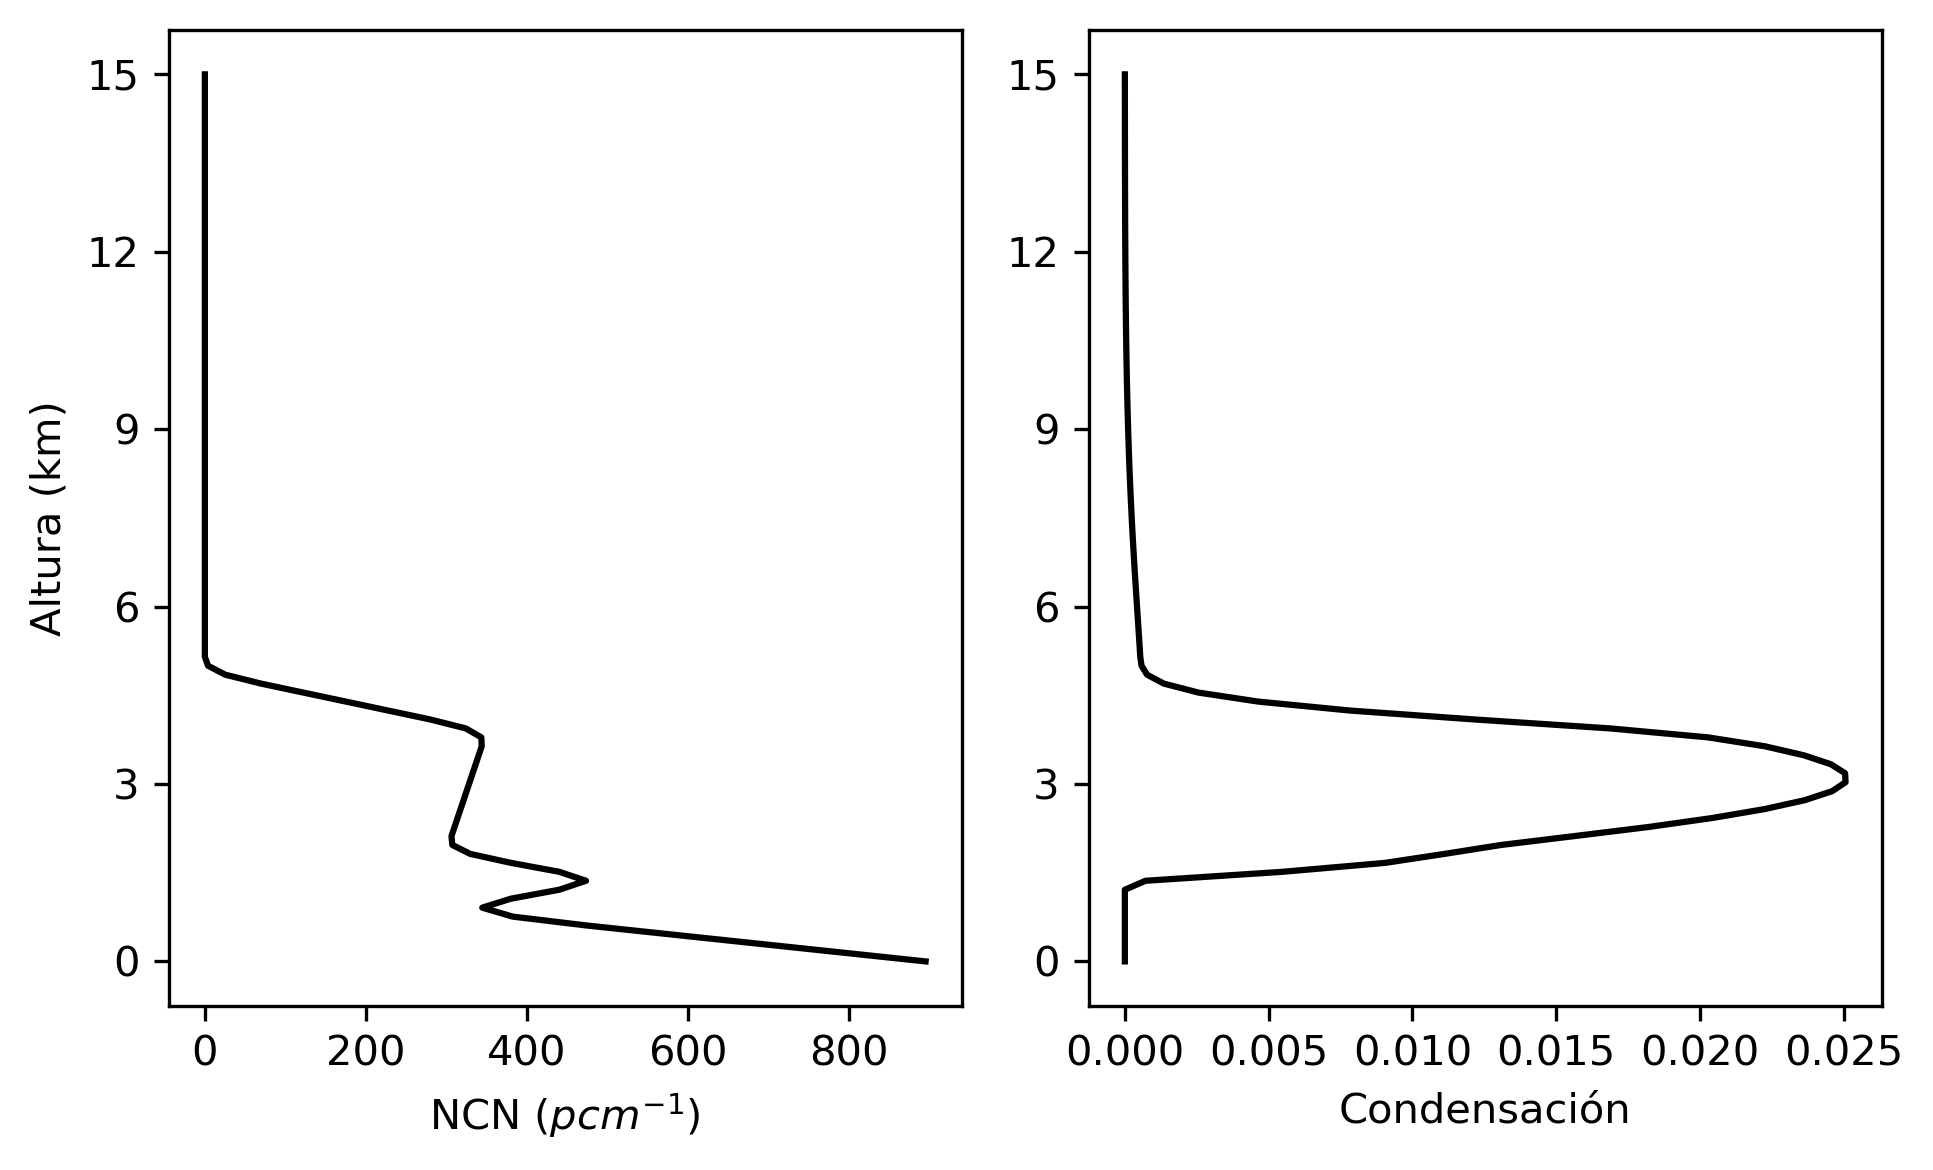

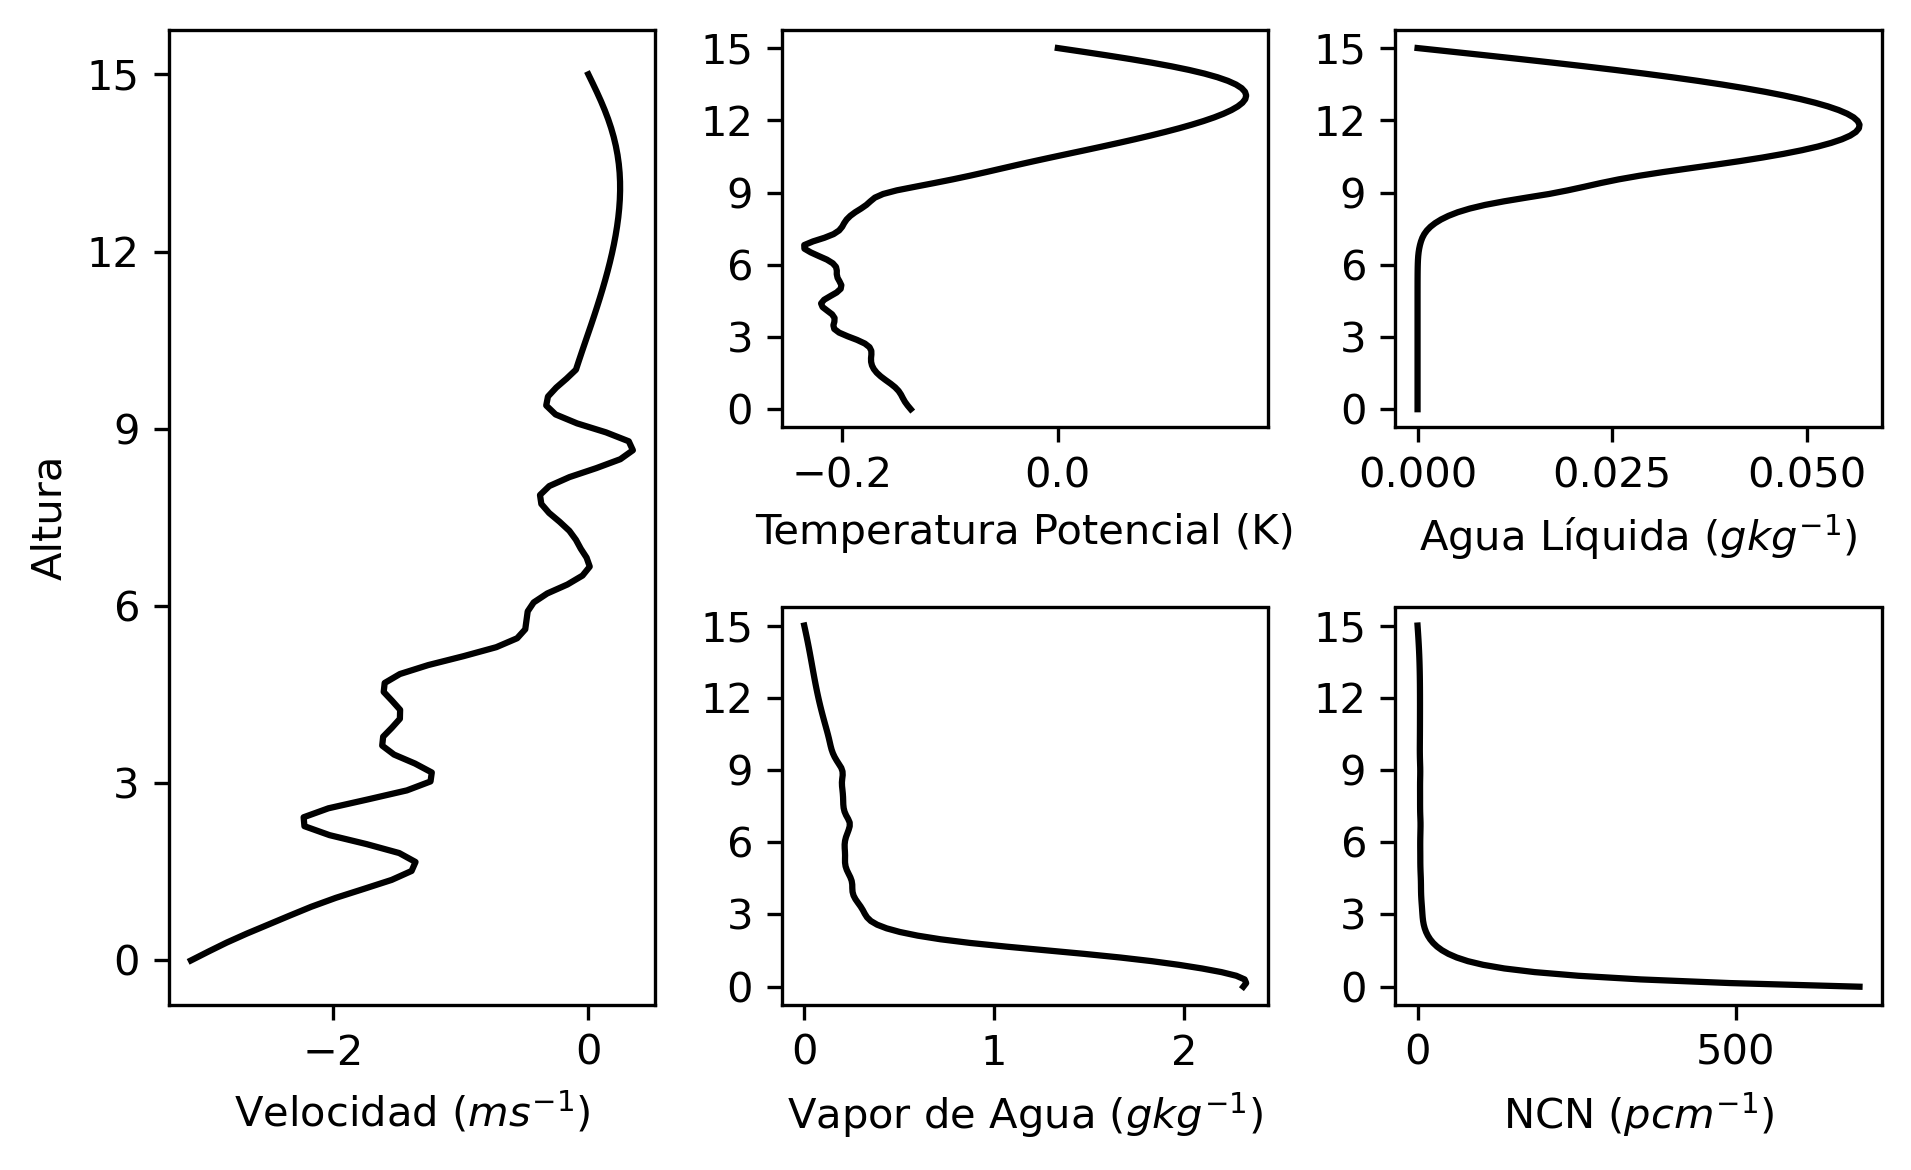

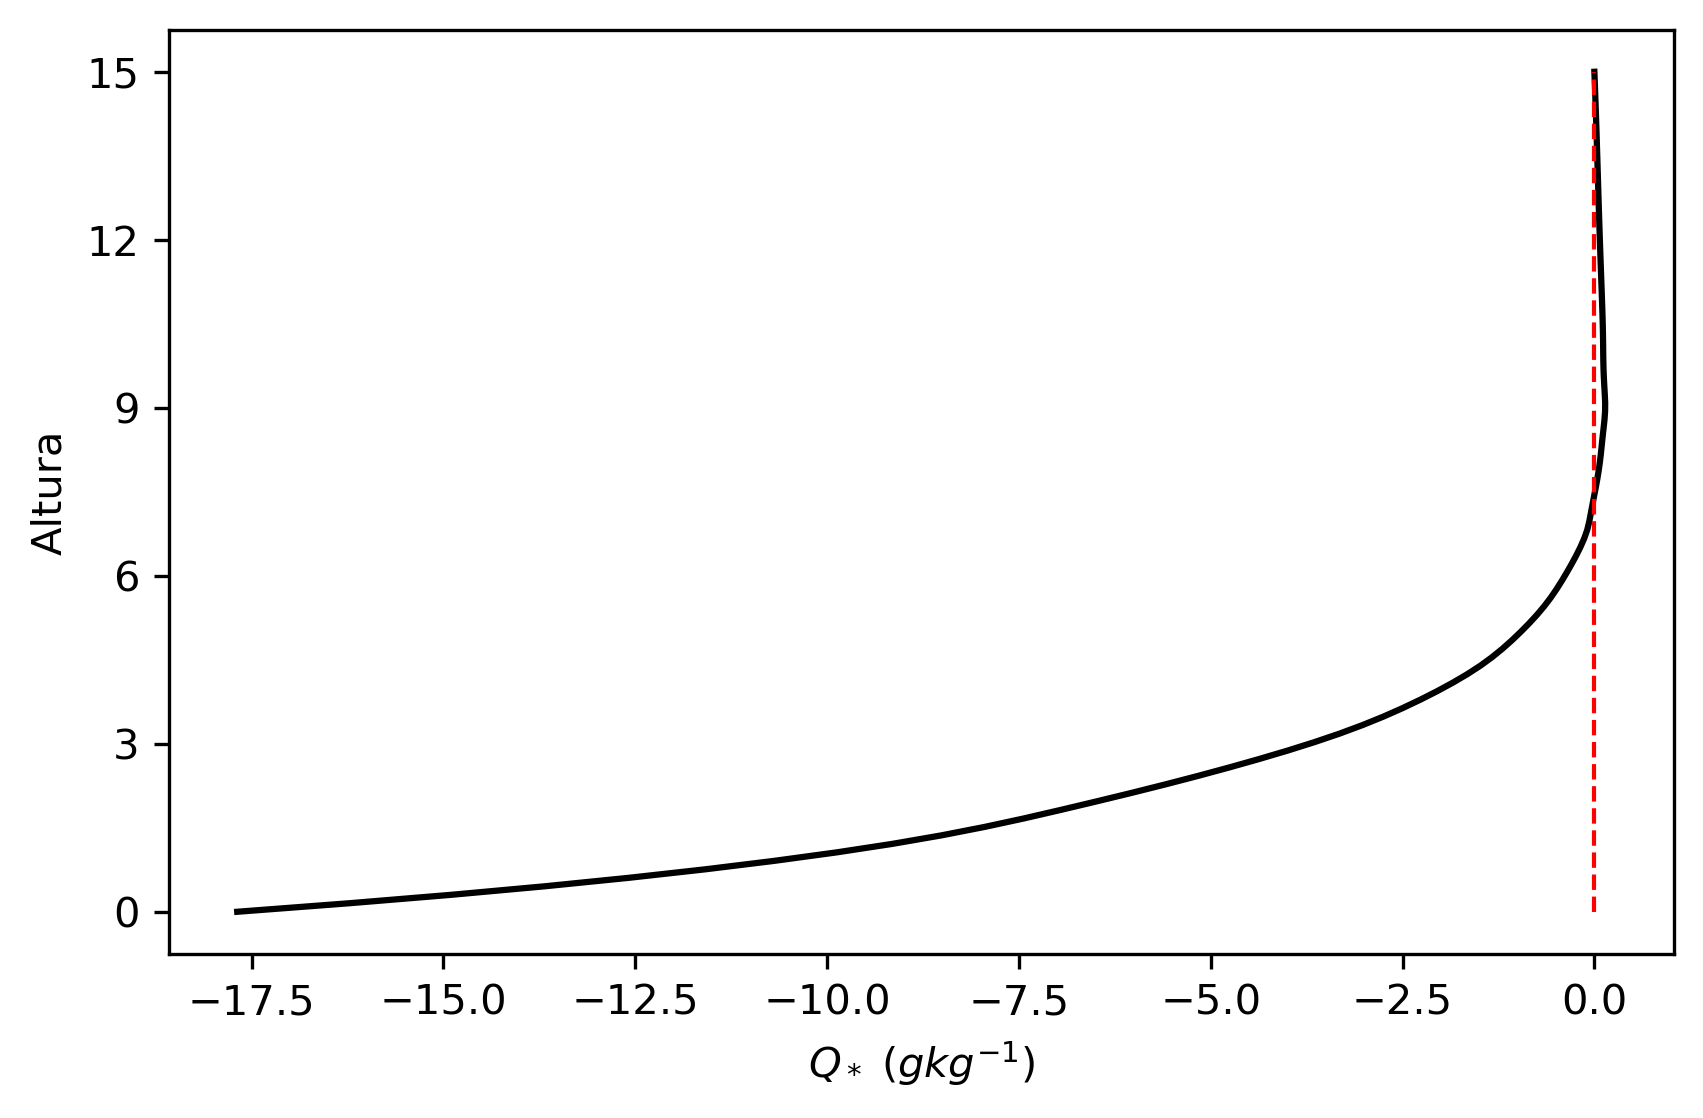

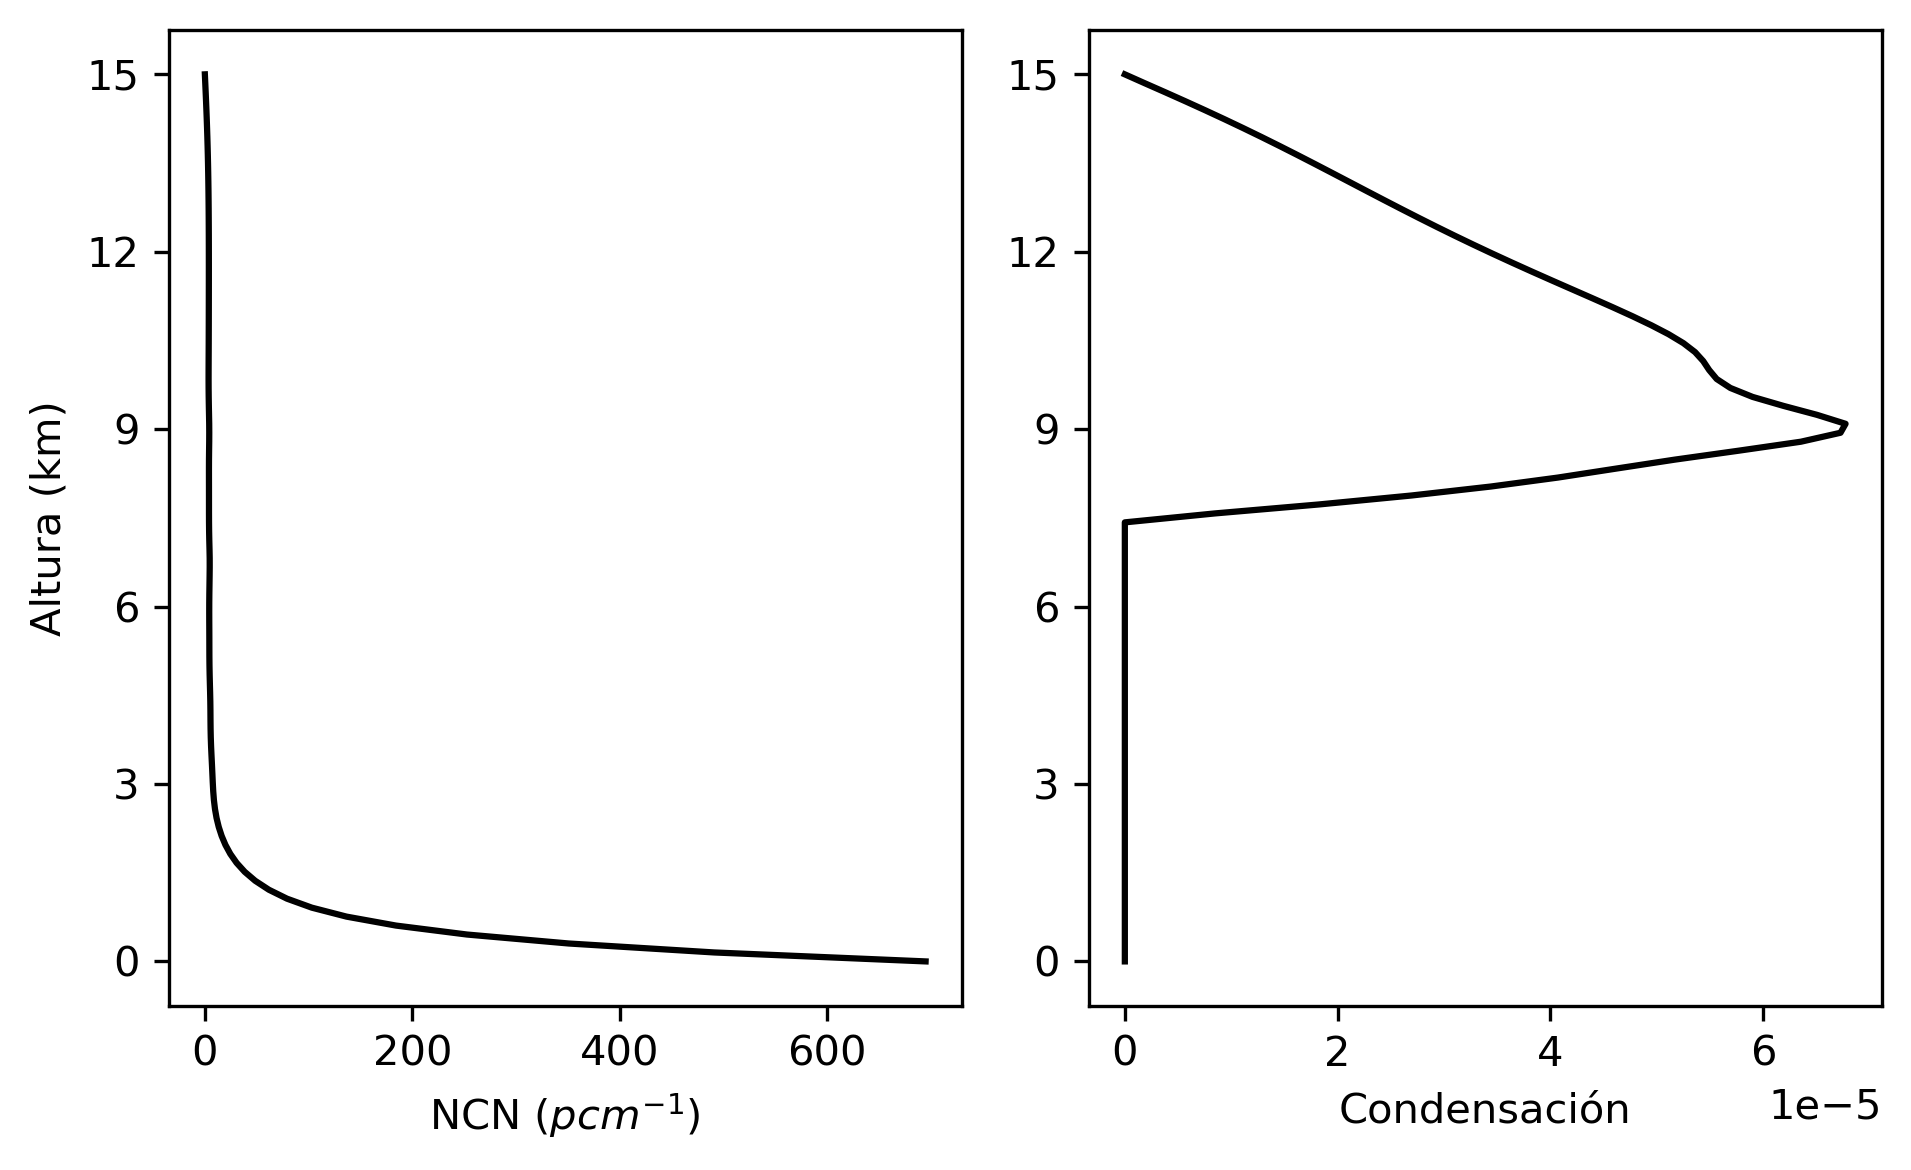

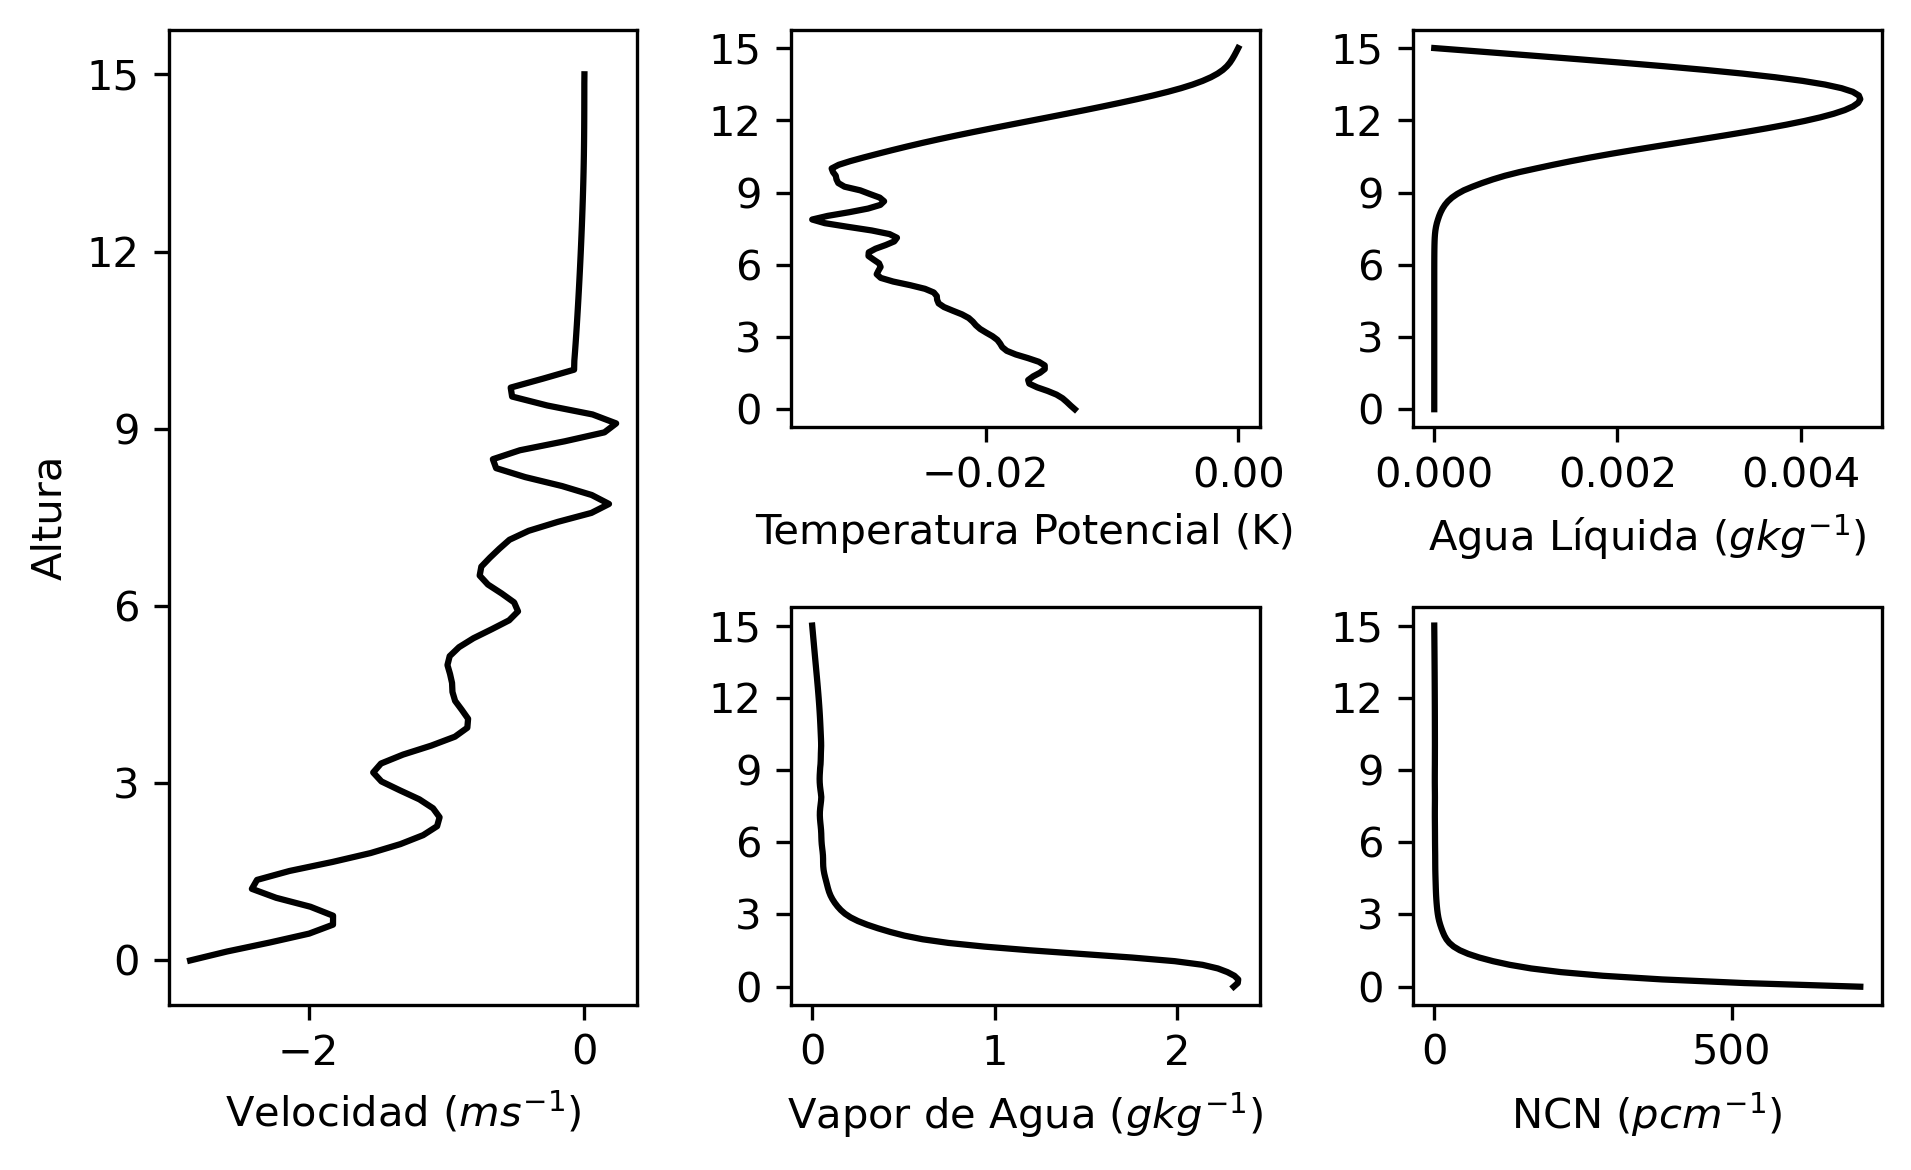

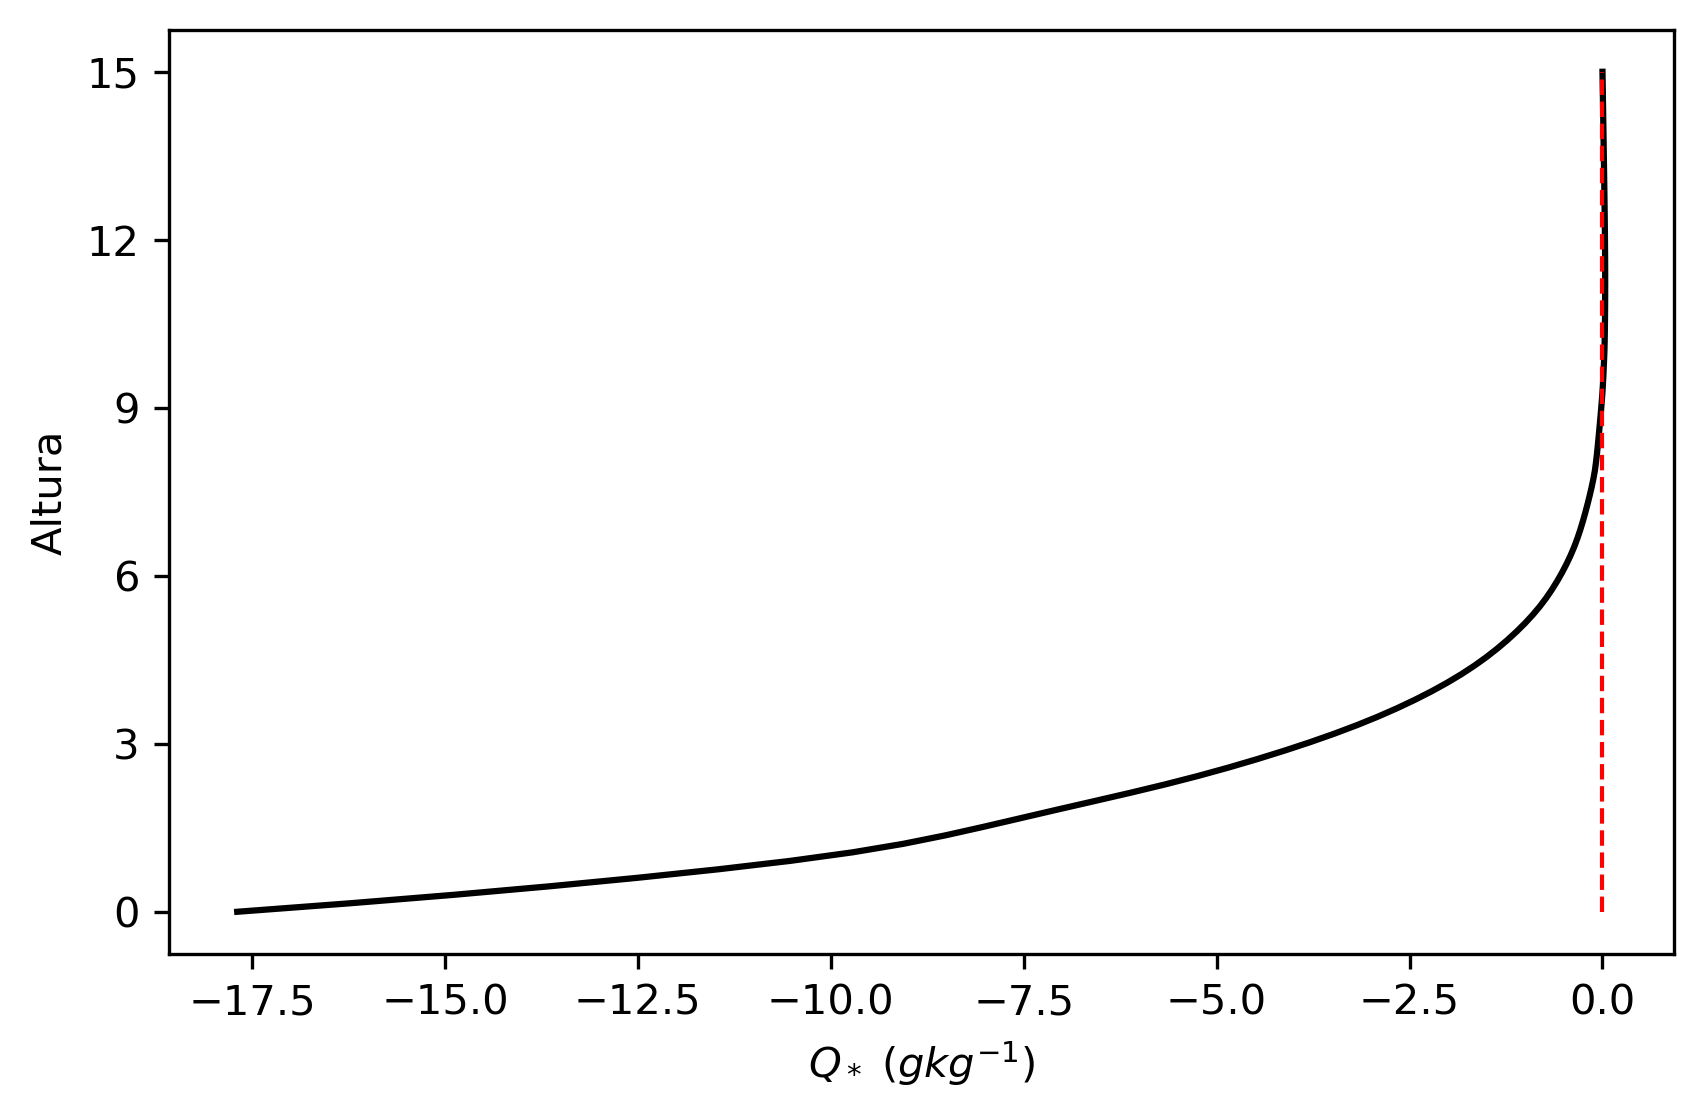

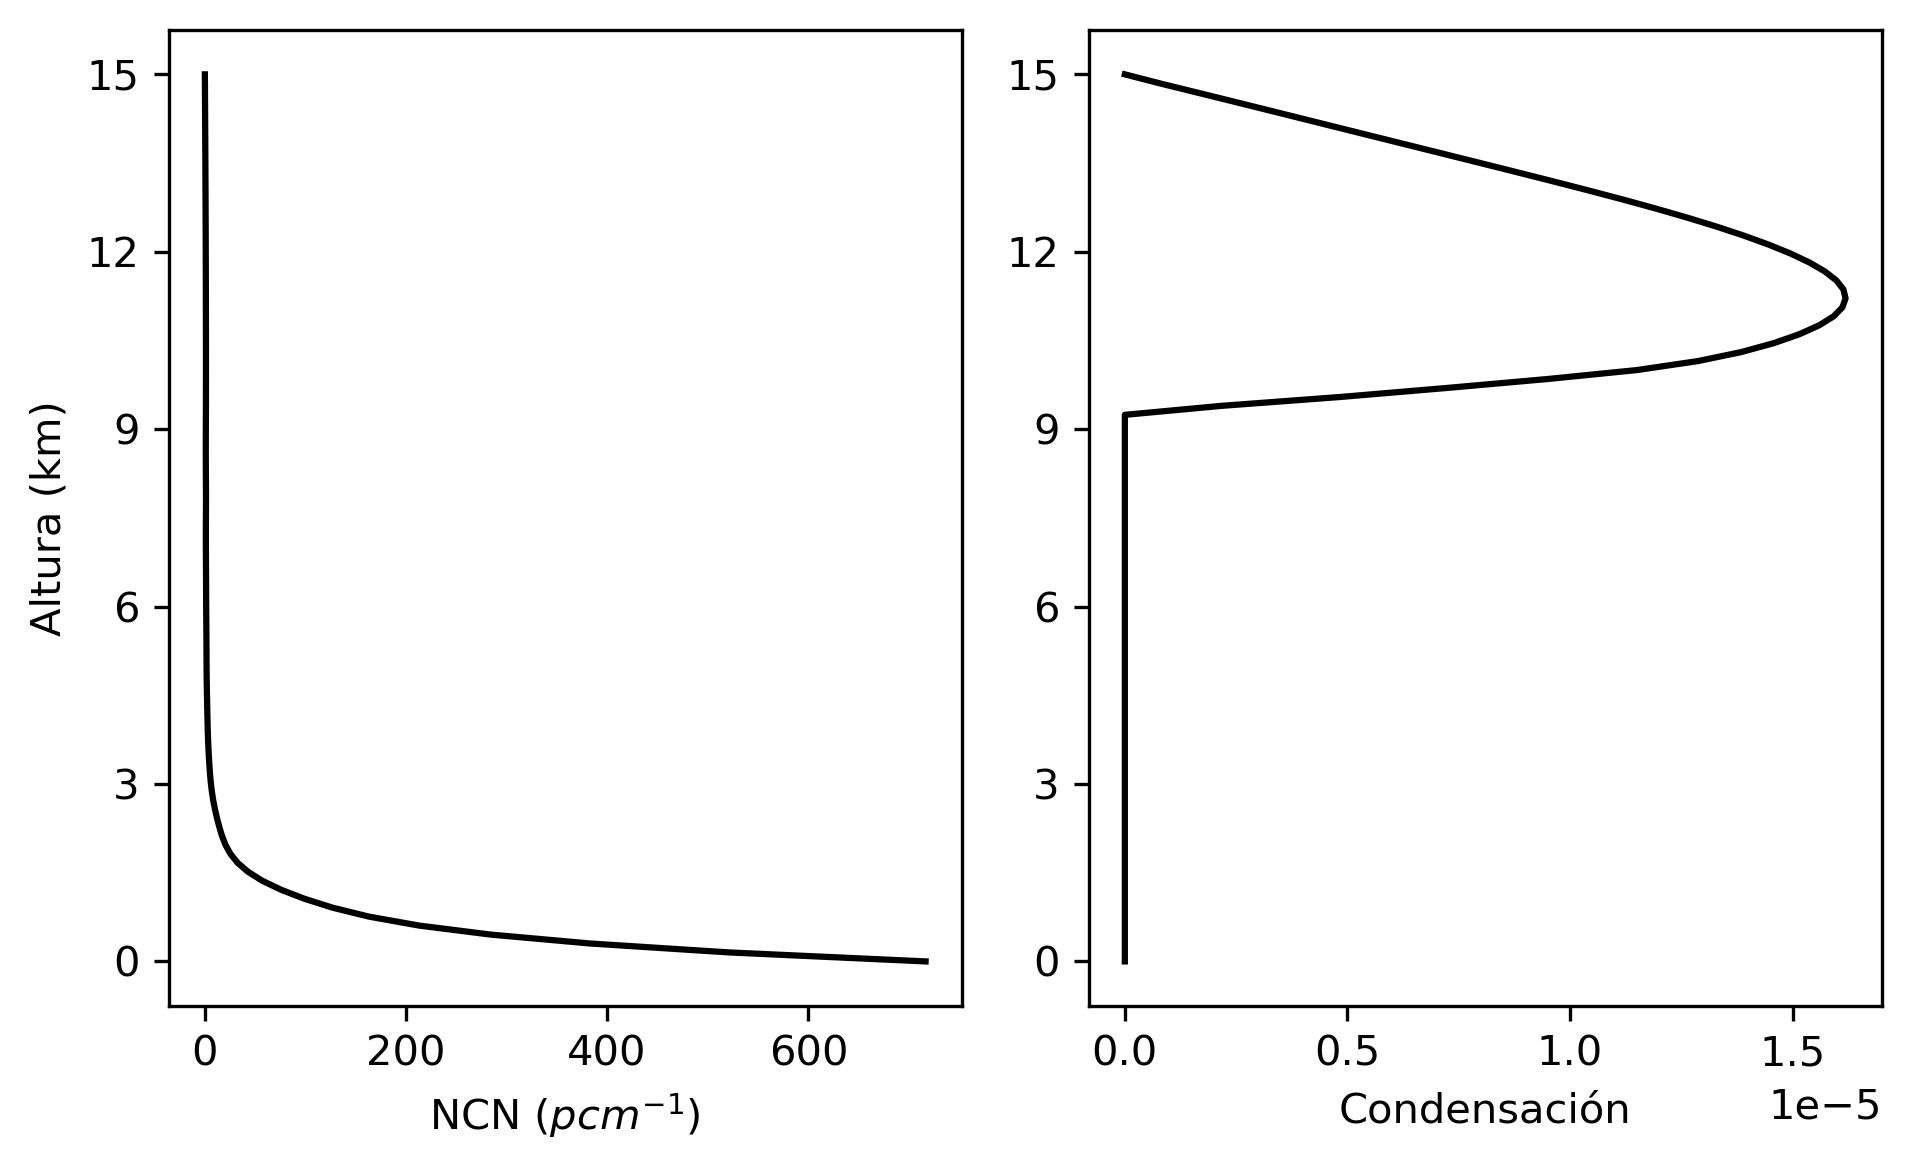

In [4]:
def qn_cond(d1):
    height = d1.index
    qv = d1['water vapor'].to_list()
    qn = d1['CNN'].to_list()
    condensation = [cd(qv[i], qn[i], q_vs(height[i] / Ls)) for i in range(len(height))]
    condensation = np.array(condensation)
    fig = plt.figure(figsize=(6.472,4), dpi=300)
    gs = fig.add_gridspec(1,2)
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax0.plot(d1['CNN'] * CNNs, height, color = 'black')
    ax0.set_xlabel(r'NCN ($pcm^{-1}$)')
    ax0.set_ylabel('Altura (km)')
    ax0.set_yticks([0,3,6,9,12,15])
    ax1.plot(condensation * qs / (Ts * 60), height, color = 'black')
    ax1.set_yticks([0,3,6,9,12,15])
    ax1.set_xlabel(r'Condensación')
    plt.tight_layout()
    return fig

def graphics(index, **kwargs):
    mode = kwargs.get('mode', 'stocha')
    for i in index:
        d1 = read_tesis_data(i, **kwargs)
        f1 = general_plot(d1)
        f1.savefig(f'plots\\{mode}_General_Plot_10t{i}.png')
        f2 = plot_q(d1)
        f2.savefig(f'plots\\{mode}_Q_plot_10t{i}.png')
        f3 = qn_cond(d1)
        f3.savefig(f'plots\\{mode}_qn_vs_cond_10t{i}.png')


graphics([1,50,101])



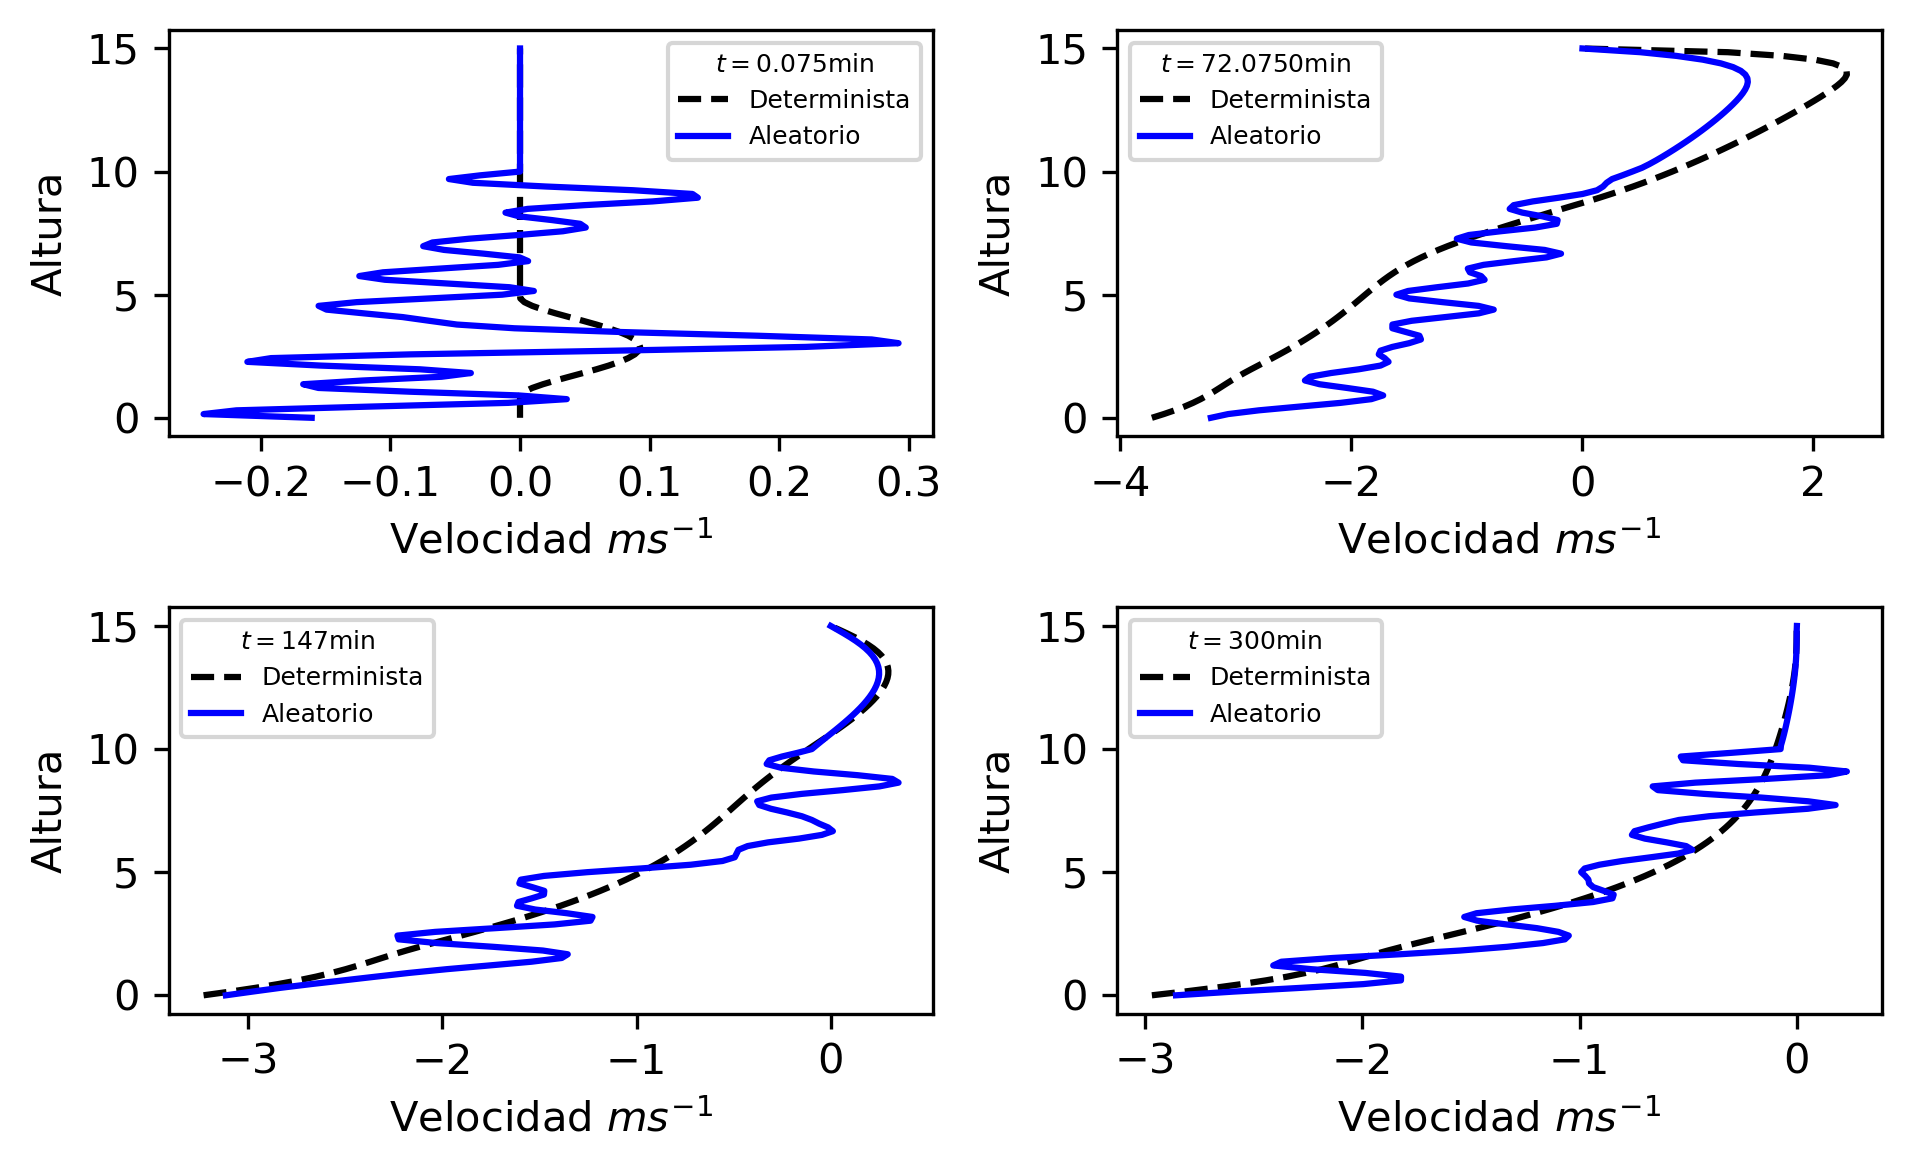

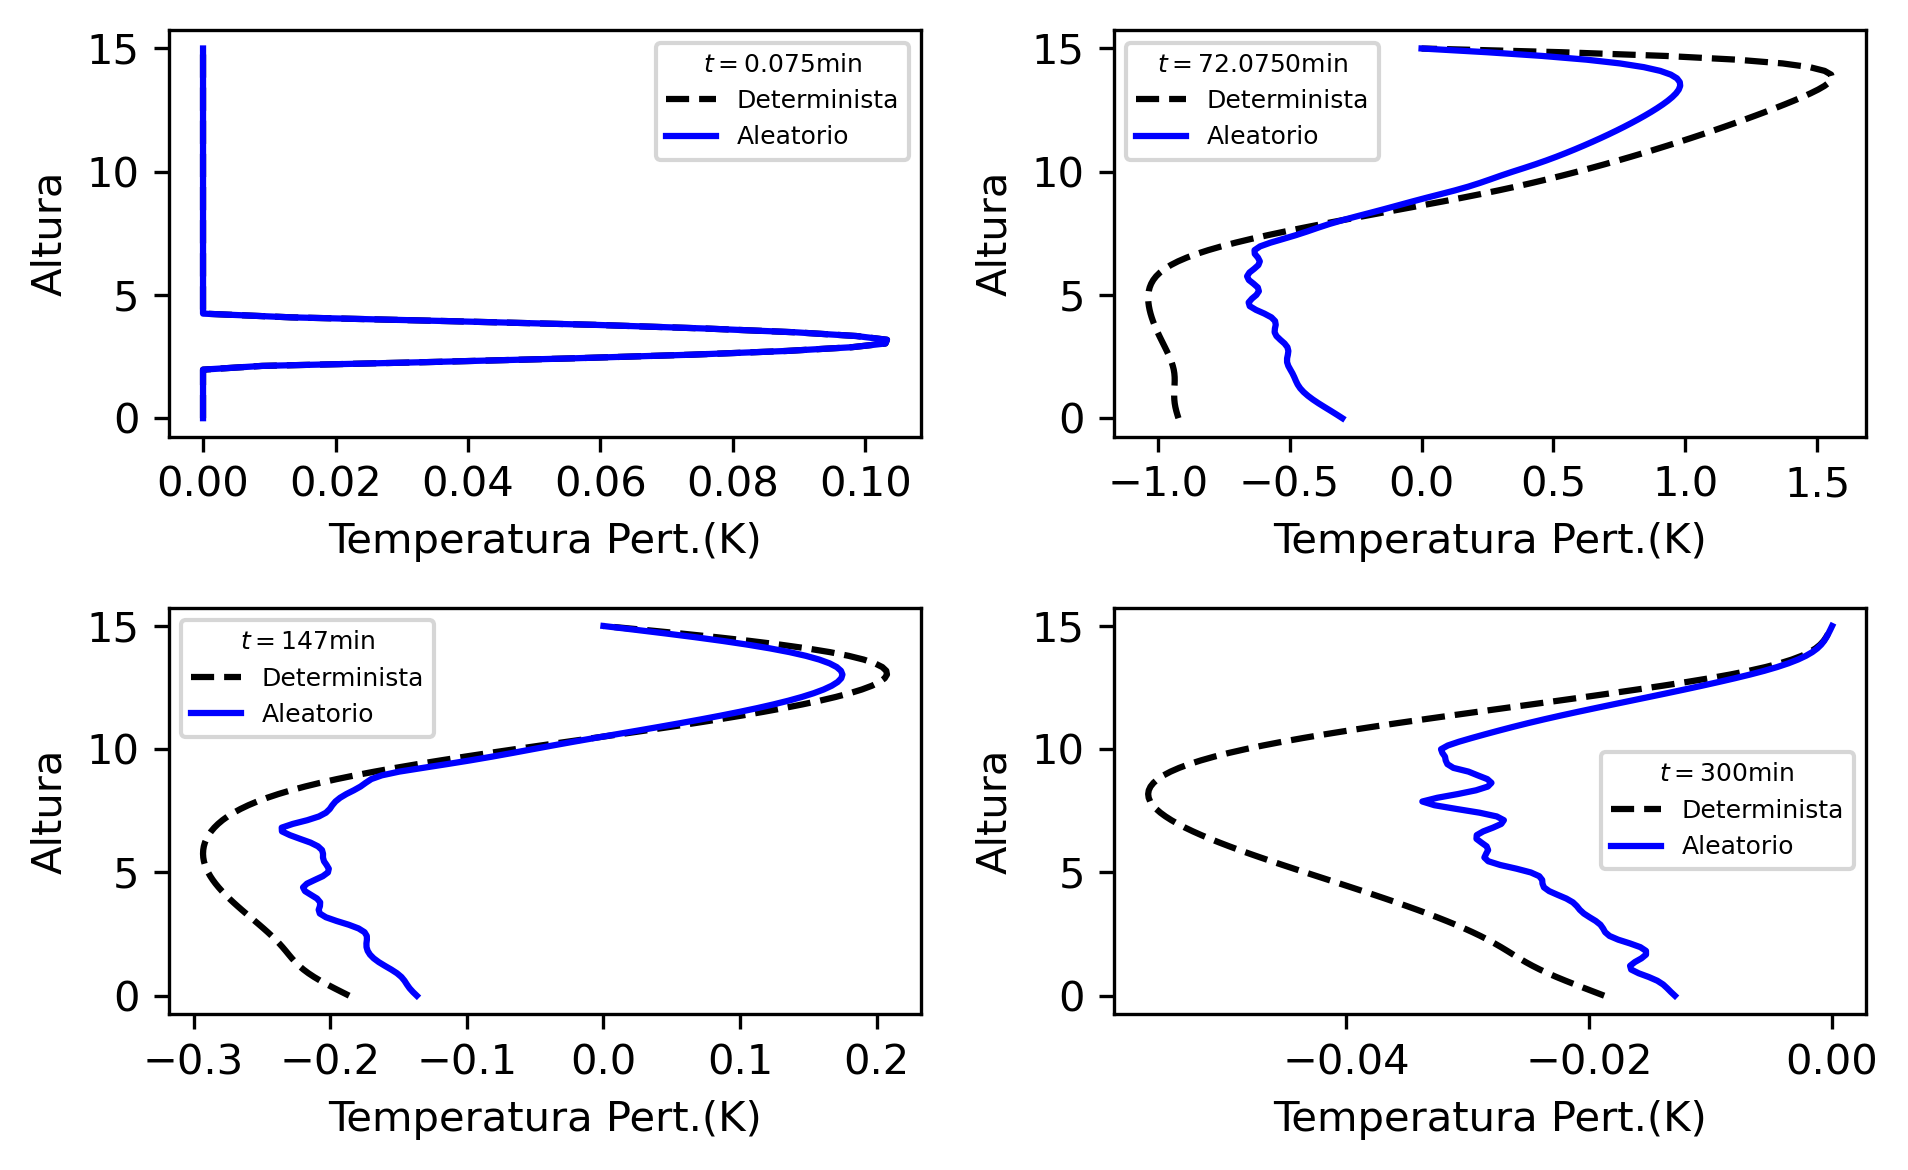

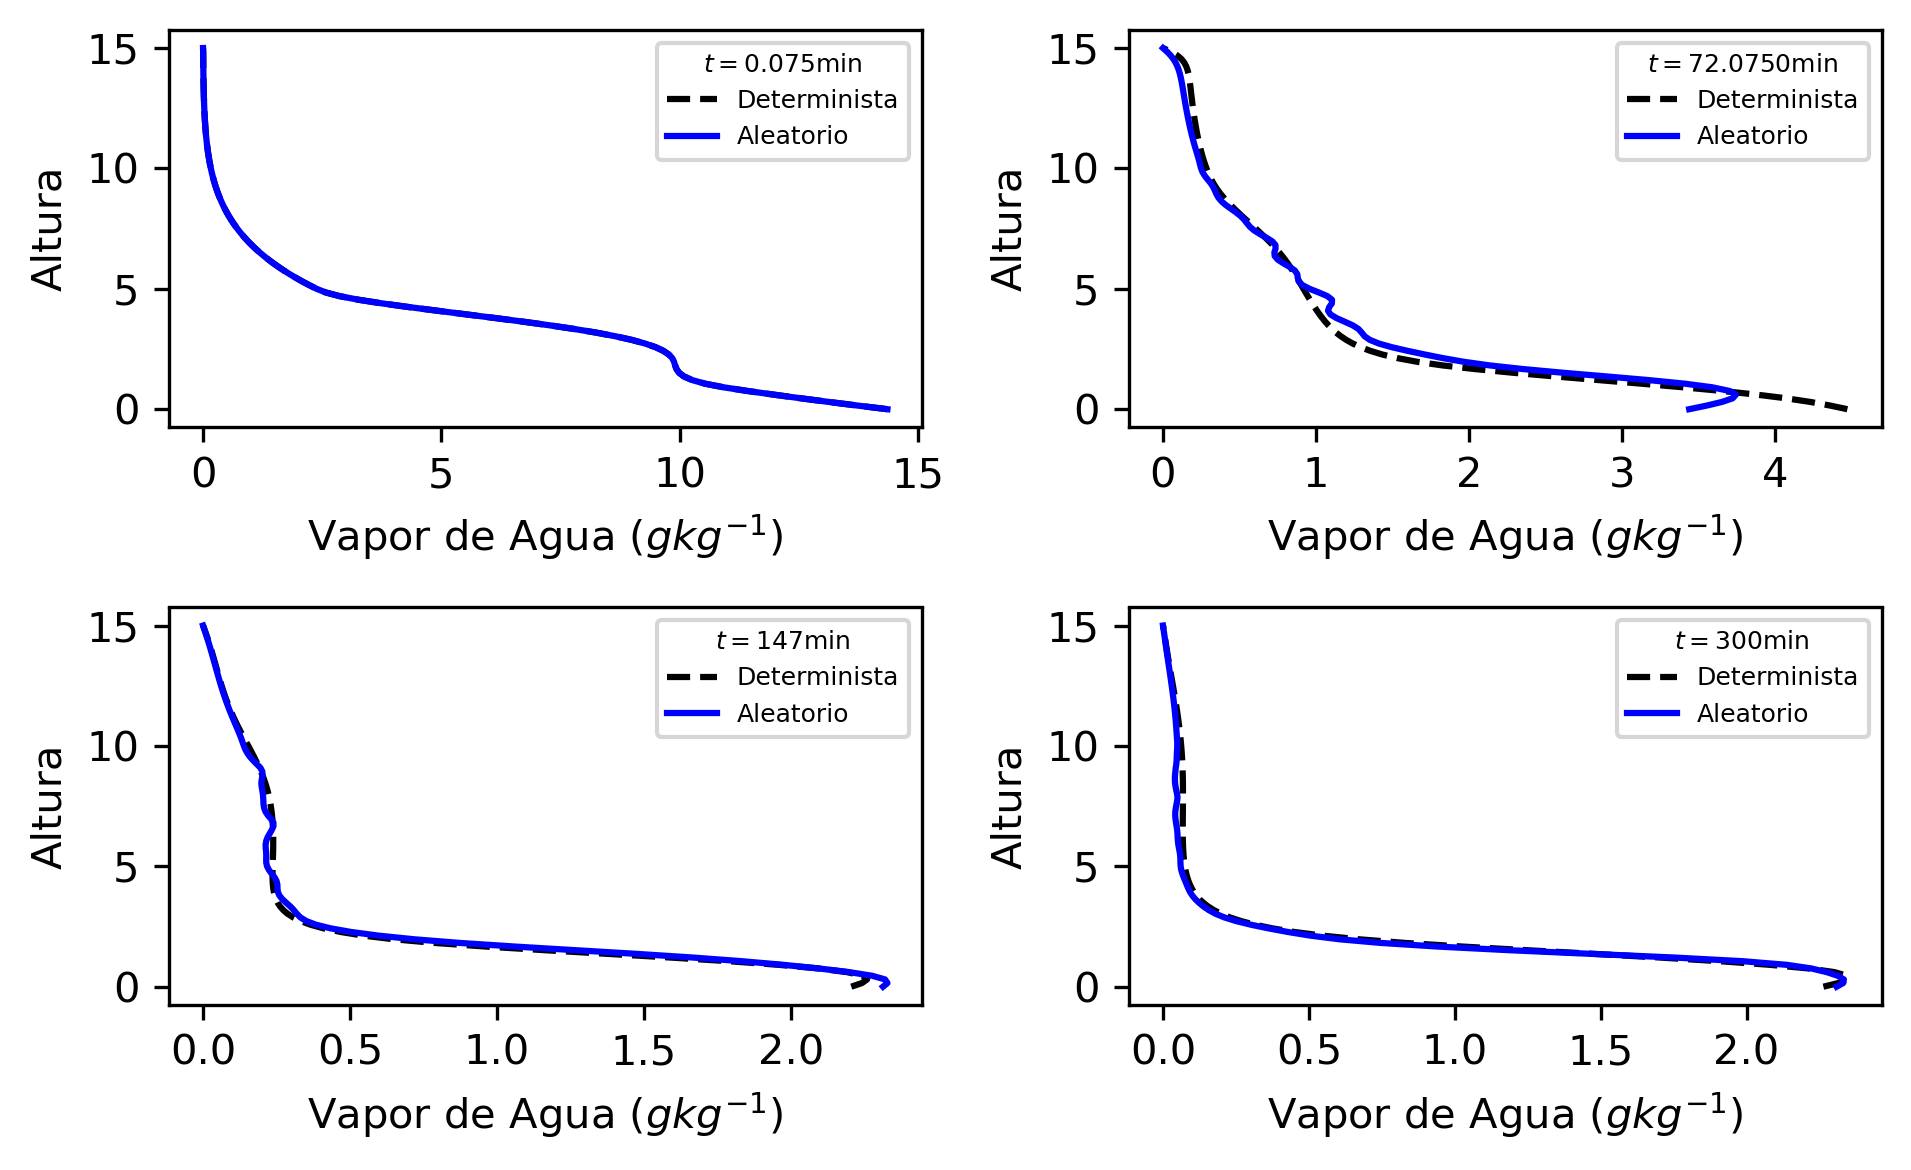

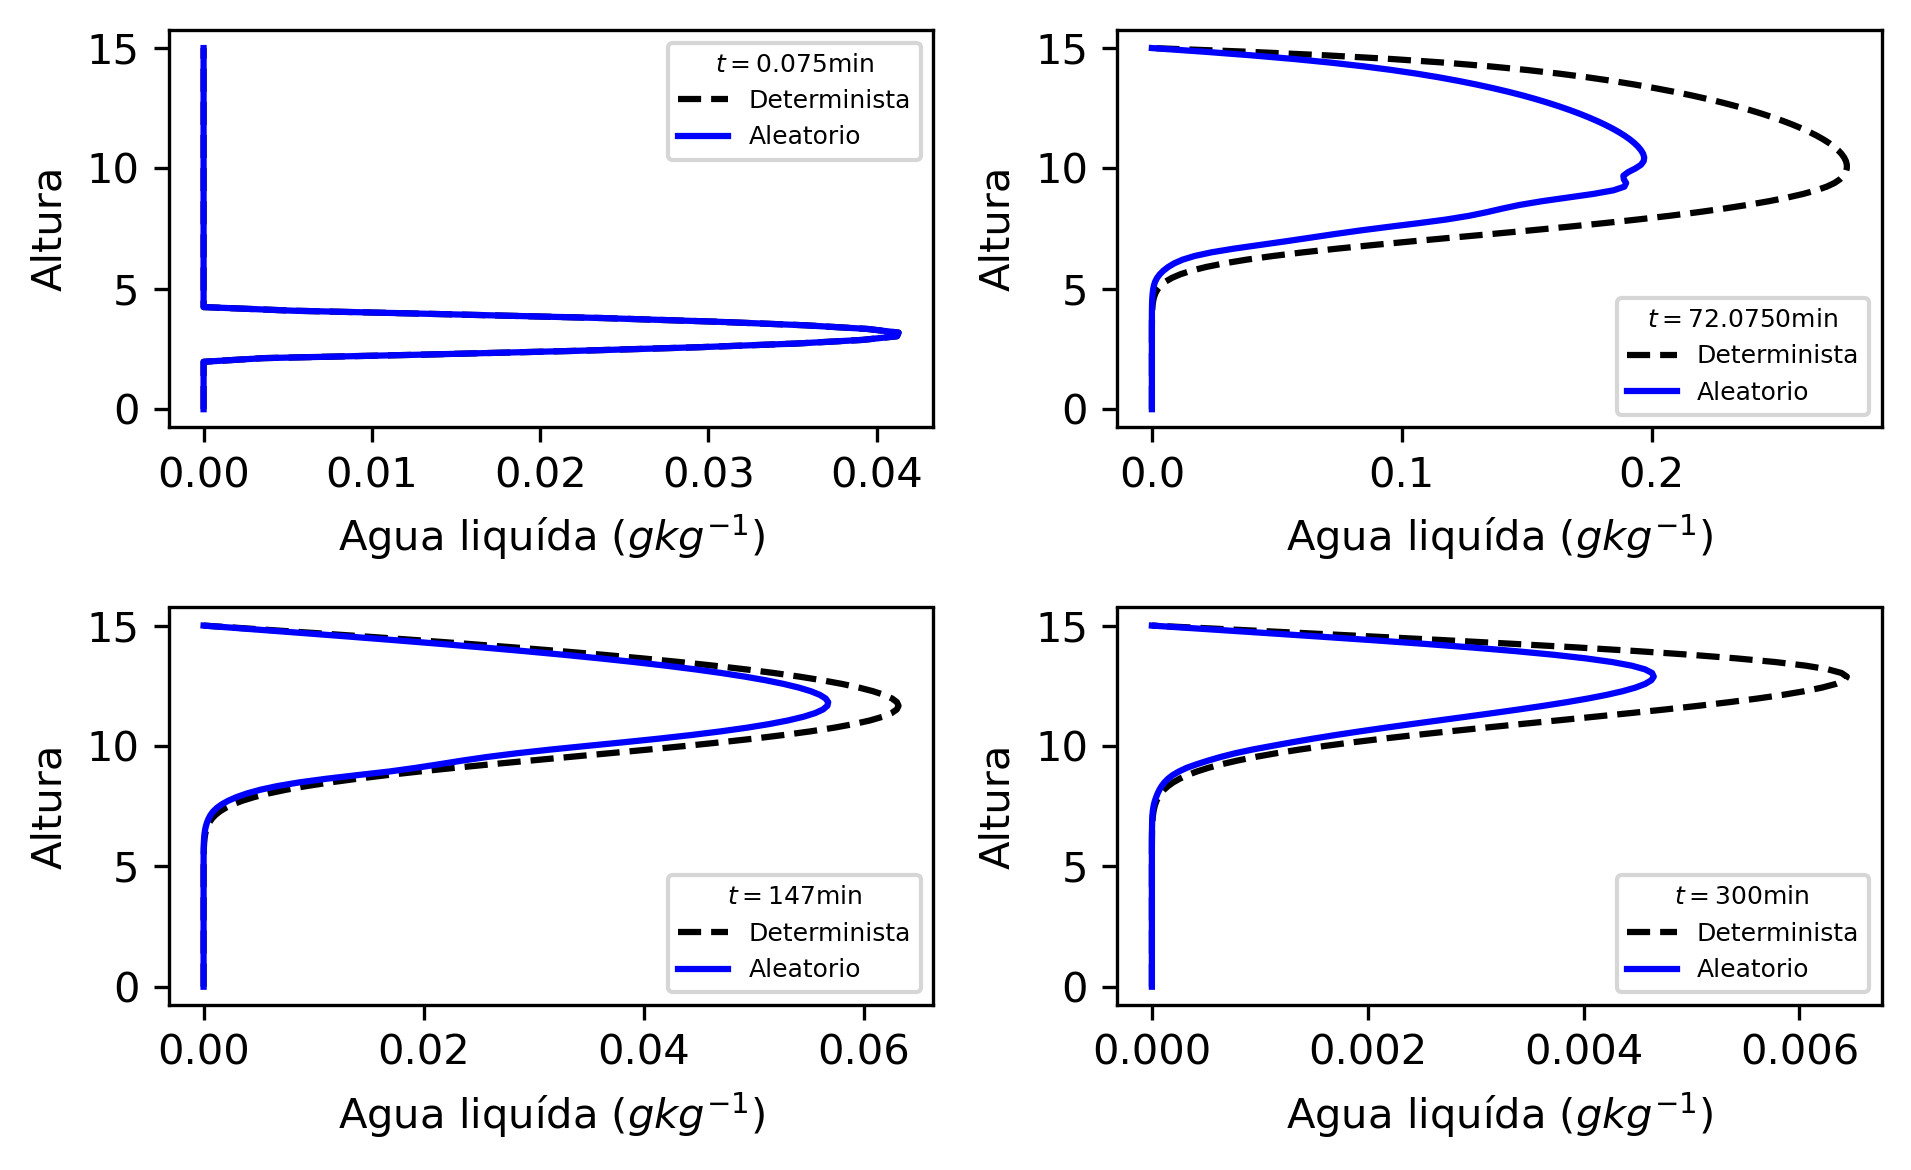

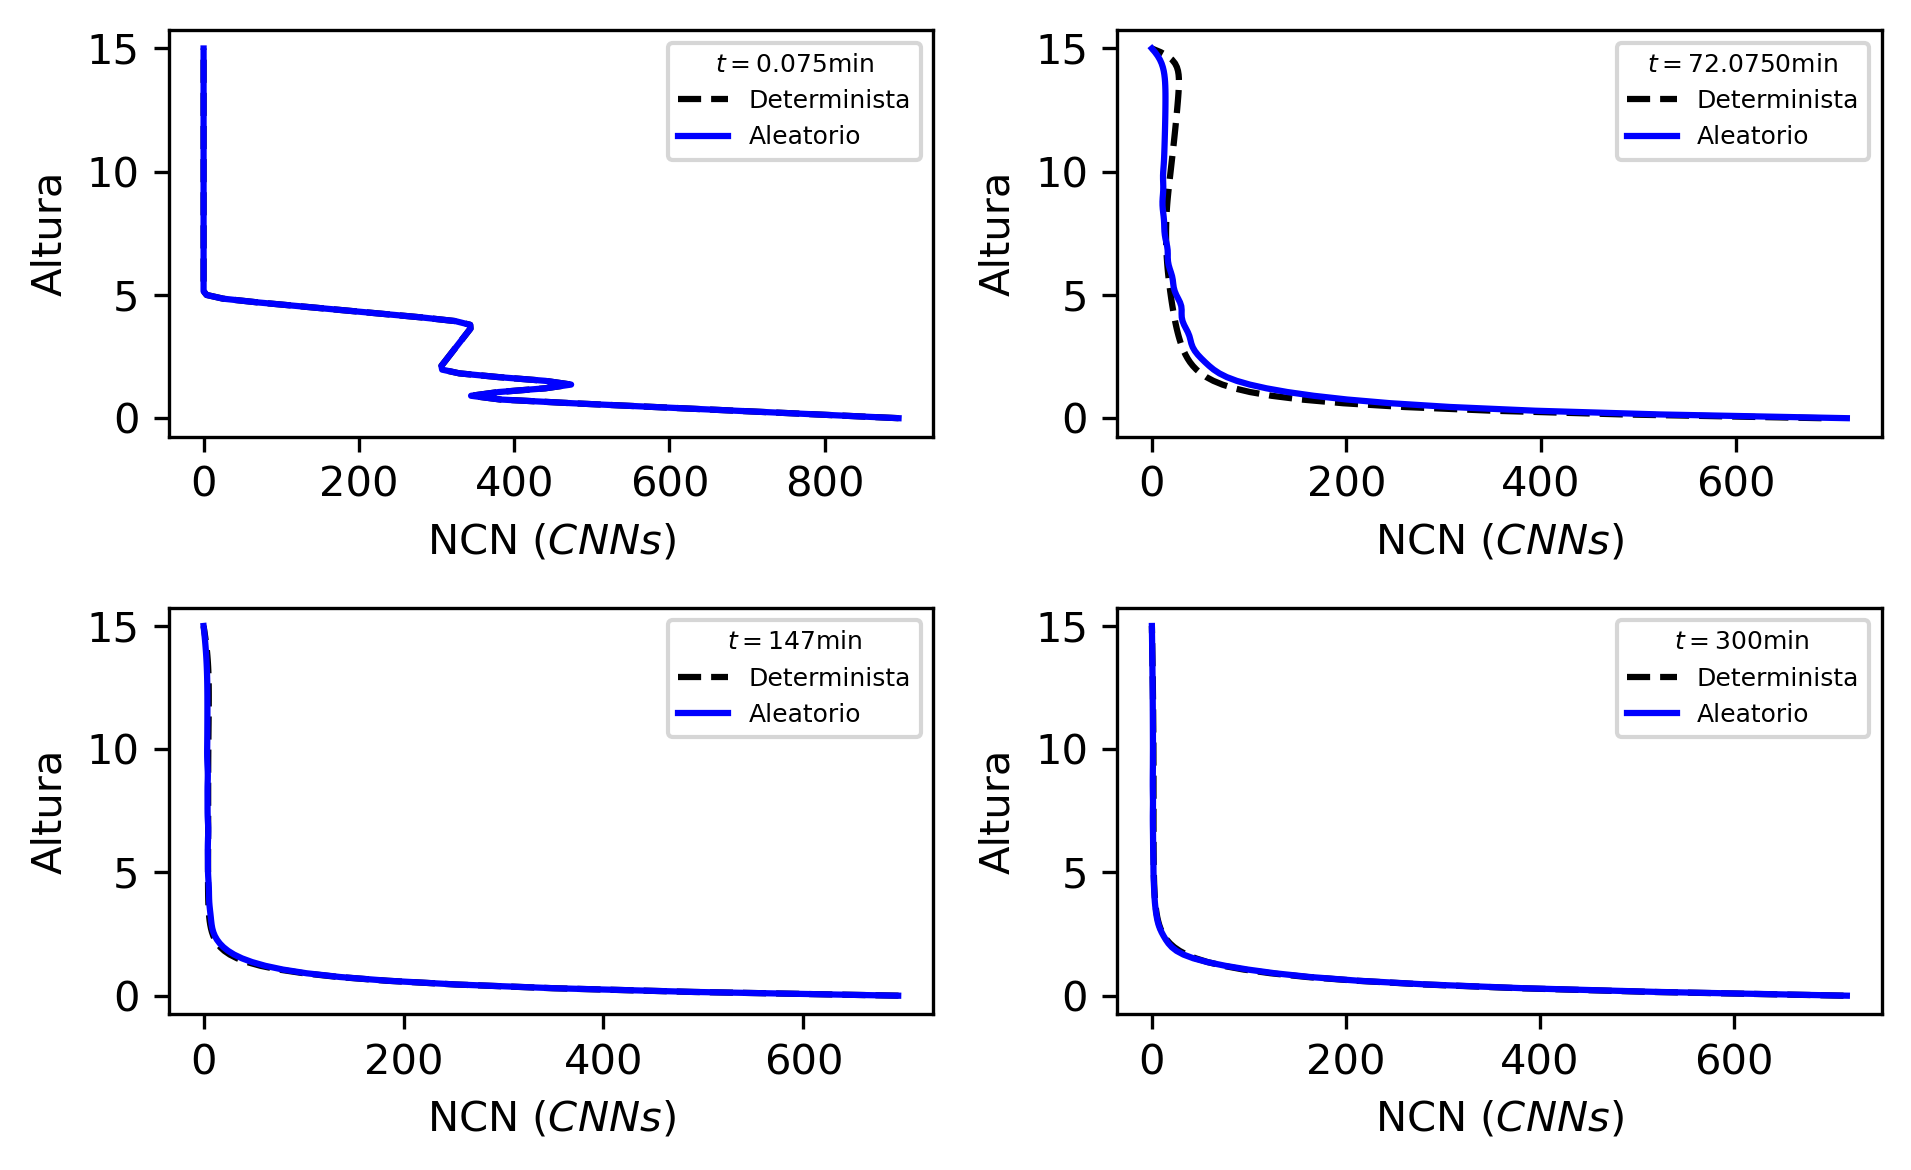

In [5]:
def det_sto_plot(index, ax, **kwargs):
    x_label = kwargs.get('labels', None)
    col = kwargs.get('plot_col', ['CNN', CNNs])
    figt = kwargs.get('leg_title', None)
    det = read_tesis_data(index, mode = 'deter')
    stocha = read_tesis_data(index)
    height = det.index
    ax.plot(det[col[0]] * col[1], height, 'k--')
    ax.plot(stocha[col[0]] * col[1], height, color = 'blue')
    ax.set_xlabel(x_label)
    ax.set_ylabel('Altura')
    ax.legend(['Determinista', 'Aleatorio'], prop=dict(size=6), title = figt, title_fontsize = 6)

def deter_vs_stocha(index, **kwargs):
    figt = kwargs.get('list_title', None)
    x_labels = kwargs.get('lxbels', None)
    col = kwargs.get('plotcol', ['CNN', CNNs])
    fig = plt.figure(figsize=(6.472,4), dpi=300)
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0,0])
    ax25 = fig.add_subplot(gs[0,1])
    ax50 = fig.add_subplot(gs[1,0])
    ax101= fig.add_subplot(gs[1,1])
    axes = [ax1, ax25,ax50, ax101]
    for axi, i in enumerate(index):
        det_sto_plot(i, axes[axi],
                     leg_title = figt[axi], labels = x_labels, plot_col = col)
    fig.tight_layout()
    fig.savefig(f'det_vs_sto_{col[0]}.png')
    return fig


s = deter_vs_stocha([1,25,50,101], plotcol = ['velocity', Us],
                     list_title = [r'$t = 0.075$min',r'$t = 72.0750$min',r'$t = 147$min',r'$t =300$min '],
                     lxbels = r'Velocidad $ms^{-1}$')
s = deter_vs_stocha([1,25,50,101], plotcol = ['potential temperature', Ths],
                     list_title = [r'$t = 0.075$min',r'$t = 72.0750$min',r'$t = 147$min',r'$t =300$min '],
                     lxbels = r'Temperatura Pert.(K)')
s = deter_vs_stocha([1,25,50,101], plotcol = ['water vapor', qs],
                     list_title = [r'$t = 0.075$min',r'$t = 72.0750$min',r'$t = 147$min',r'$t =300$min '],
                     lxbels = r'Vapor de Agua ($gkg^{-1}$)')
s = deter_vs_stocha([1,25,50,101], plotcol = ['liquid water', qs],
                     list_title = [r'$t = 0.075$min',r'$t = 72.0750$min',r'$t = 147$min',r'$t =300$min '],
                     lxbels = r'Agua liquída ($gkg^{-1}$)')
s = deter_vs_stocha([1,25,50,101], plotcol = ['CNN', CNNs],
                     list_title = [r'$t = 0.075$min',r'$t = 72.0750$min',r'$t = 147$min',r'$t =300$min '],
                     lxbels = r'NCN ($CNNs$)')



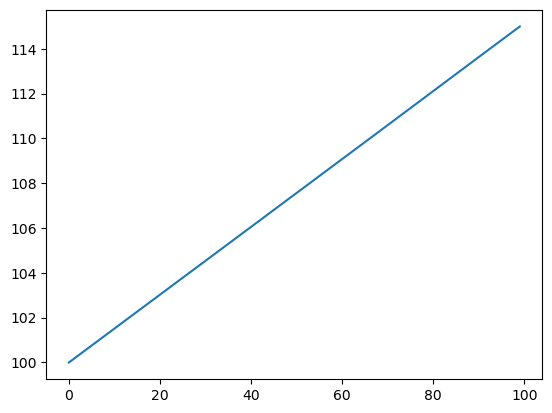

In [6]:
theta0 = 300
theta0 = theta0/Ths
B = 3
B = B*Ls/Ths


def calc_tp(i, theta_0, B, **kwargs):
    mode = kwargs.get('modes', 'stocha')
    d1 = read_tesis_data(i, mode = mode)
    height = d1.index
    theta_pert = d1['potential temperature'].to_list()
    theta_env = [theta_0 + B* z / Ls for z in height]
    temp_pot = [theta_pert[i] + theta_env[i] for i in range(len(height))]
    return temp_pot


temp_potential = calc_tp(101, theta0, B)


plt.plot(temp_potential)